<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%202/MINE4210_ADL2024_Lab2_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

**Tutores**.
* Nicolás Tibatá Casteñeda.
* Fabián Camilo Castellanos P.

#Tabla de contenido

[Contexto y objetivos.](#scrollTo=akPpjfYNdr_e)<br>
[Entendimiento del negocio.](#scrollTo=9Z27r_jyhua_)<br>
[0. Instalación de librerías.](#scrollTo=0hPv6Krqduo8)<br>
[1. Importar librerías](#scrollTo=tcBjam38jYmd)<br>
[2. Introducción a los datos.](#scrollTo=J0LiqMmwufw8)<br>
[3. Modelamiento.](#scrollTo=4G324-9N8_zJ)<br>
[4. Preguntas.](#scrollTo=jDjj_B--9HZ5)<br>


# **Laboratorio 2 - Sesión 1**
## **Redes Convolucionales**

## **Objetivos**
*   Realizar la carga y procesamiento de imágenes.
*   Analizar la estructura de una Red Neuronal Convolucional.
*   Revisar los diferentes conceptos de las Redes Neuronales Convolucionales.


## **Problema**
- Uno de los grandes avances que se han propuesto a través de la Visión por Computador es la clasificación de imágenes. Donde a través de ellas se puede establecer directamente a que clase o etiqueta pertenece una imágen sin necesidad de intervención humana. Así que para ello, hemos recuperado un conjunto de imágenes que nos ayudará a entender los conceptos básicos de las Redes Convolucionales a través de la [clasificación de imágenes de animales](https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset).

# Entendimiento del negocio.

Para tener un mejor detalle sobre el comportamiento de las variables, solicitamos a la organización el diccionario de datos y nos suministró la siguiente información:

```python
datasets/
  cats/
    a_image_1.jpg
    a_image_2.jpg
    .......
  dogs/
    a_image_1.jpg
    a_image_2.jpg
    .......
  snakes/
    a_image_1.jpg
    a_image_2.jpg
    .......
```

# 0. Instalación de librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [1]:
!pip install kaggle

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.5 MB/s eta 0:00:00


---
# 1. Importar librerías

In [3]:
#Numpy y Pandas
import pandas as pd
import numpy as np
from numpy import asarray

#Librerías de Scikit Learn
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#Librerías de Keras y Tensor Flow
import tensorflow as tf
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D, Activation, Reshape
from keras import backend as K
from keras import applications
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

#Gráficos
import matplotlib.pyplot as plt
%matplotlib inline

#Otras Librerías
import os.path as osp
from PIL import Image

#Verificamos las versiones de las librerías
print(f"La versión de sklearn es: {sklearn.__version__}")
print('Tensorflow version:', tf.__version__)

La versión de sklearn es: 1.3.2
Tensorflow version: 2.17.0


Este fragmento de código, nos permite evaluar si tenemos disponible una GPU dentro del ambiente de Google Colab:

In [4]:
device_name = tf.test.gpu_device_name()
gpu_name = '/device:GPU:0'
if device_name != gpu_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


---
# 2. Introducción a los datos.

##2.1. Parámetros generales y carga de la información.

Los parámetros de porcentaje de datos de prueba y la reproducibilidad:

In [5]:
#Porcentaje para validación y test
test_alpha = 0.2
#random_state o semilla para la reproducibilidad
my_seed = 19

Definimos algunos parámetros, como el tamaño del batch y el tamaño de las imágenes a cargar.

In [6]:
batch_size = 32
img_height = 256
img_width = 256

## 2.2. Configuración del entorno de kaggle.

Preparar el archivo de kaggle para la descarga

In [7]:
!ls -lha kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 69 Sep  6 00:49 kaggle.json


Verificamos la conectividad con kaggle, usando un comando para ver una previsualización de datasets:

In [8]:
!kaggle datasets list

ref                                                               title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                      Student Performance Predictions                      9KB  2024-08-17 06:57:57           7428        162  0.9411765        
berkayalan/paris-2024-olympics-medals                             Paris 2024 Olympics Medals                           1KB  2024-08-14 11:02:45           6072        107  1.0              
lainguyn123/student-performance-factors                           Student Performance Factors                         94KB  2024-09-02 10:53:57           1483         40  1.0              
lainguyn123/australia-car-market-data                  

Una vez hemos asegurado la conectividad, procedemos a realizar el proceso de descarga de la información del negocio.

In [9]:
!kaggle datasets download borhanitrash/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
 89% 34.0M/38.4M [00:02<00:00, 19.4MB/s]
100% 38.4M/38.4M [00:02<00:00, 17.2MB/s]


La información descargada en formato zip, cuenta con un archivo csv en su interior, si vieramos de forma gráfica su estructura, sería la siguiente:

```python
animal-image-classification-dataset.zip/
  Animals/
    cats/
      a_image_1.jpg
      a_image_2.jpg
      .......
    dogs/
      a_image_1.jpg
      a_image_2.jpg
      .......
    snakes/
      a_image_1.jpg
      a_image_2.jpg
      .......
```

Teniendo en cuenta lo anterior, vamos a descomprimir la información, es necesario crear un un directorio para que el contenido del archivo zip, se encuentre allí. Para este propósito, vamos a crear unas variables de manejo de archivos:

In [10]:
ROOT_DIR = '/content'
DATASET_NAME = 'animal-image-classification-dataset'

Vamos ahora a generar una previsualización del comando de descompresión del archivo zip:

In [11]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}")

!unzip animal-image-classification-dataset.zip -d /content/animal-image-classification-dataset


Ahora si vamos a consolidar el bloque de comandos con todos los pasos para la descompresión del archivo zip:

In [12]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  animal-image-classification-dataset.zip
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0001.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0002.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0003.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0004.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0005.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0006.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0007.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0008.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0009.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0010.jpg  
  inflating: /content/animal-image-classification-dataset/Animals/cats/0_0011.jpg  
  inflating: /con

Generamos la ruta del directorio para cargar la información:

In [13]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/Animals"
print(DATA_DIR)

/content/animal-image-classification-dataset/Animals


Generamos las particiones de los datos (80% train, 10% validación, 10% test):

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  label_mode='categorical',
  validation_split=test_alpha,
  subset="training",
  seed=my_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    validation_split=test_alpha / 2,
    subset="validation",
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3000 files belonging to 3 classes.
Using 300 files for validation.


In [16]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    validation_split=test_alpha / 2,
    subset="validation",
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3000 files belonging to 3 classes.
Using 300 files for validation.


Verificamos los nombres de las clases en los datos:

In [17]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs', 'snakes']


Ahora vamos a verificar los tamaños de las imágenes:

In [18]:
print("----------ENTRENAMIENTO----------")
for images, labels in train_ds.take(1):
    print("Núm. Imágenes:", images.shape)
    print("Clases:", labels.shape)
    #print("Muestra de clases:", labels.numpy())

print("----------VALIDACIÓN----------")
for images, labels in val_ds.take(1):
    print("Núm. Imágenes:", images.shape)
    print("Clases:", labels.shape)
    #print("Muestra de clases:", labels.numpy())

----------ENTRENAMIENTO----------
Núm. Imágenes: (32, 256, 256, 3)
Clases: (32, 3)
----------VALIDACIÓN----------
Núm. Imágenes: (32, 256, 256, 3)
Clases: (32, 3)


## 2.3. Exploración de los datos.

Vamos a visualizar una muestra:

In [19]:
sample_train_ds = train_ds.shuffle(buffer_size=10, seed=my_seed)
sample_train_ds = sample_train_ds.take(1)

In [20]:
sample_train_img = []
sample_train_lbl = []
for images, labels in sample_train_ds.take(1):
  for i in range(9):
    sample_train_img.append(images[i].numpy())
    sample_train_lbl.append(class_names[labels[i].numpy().argmax()])

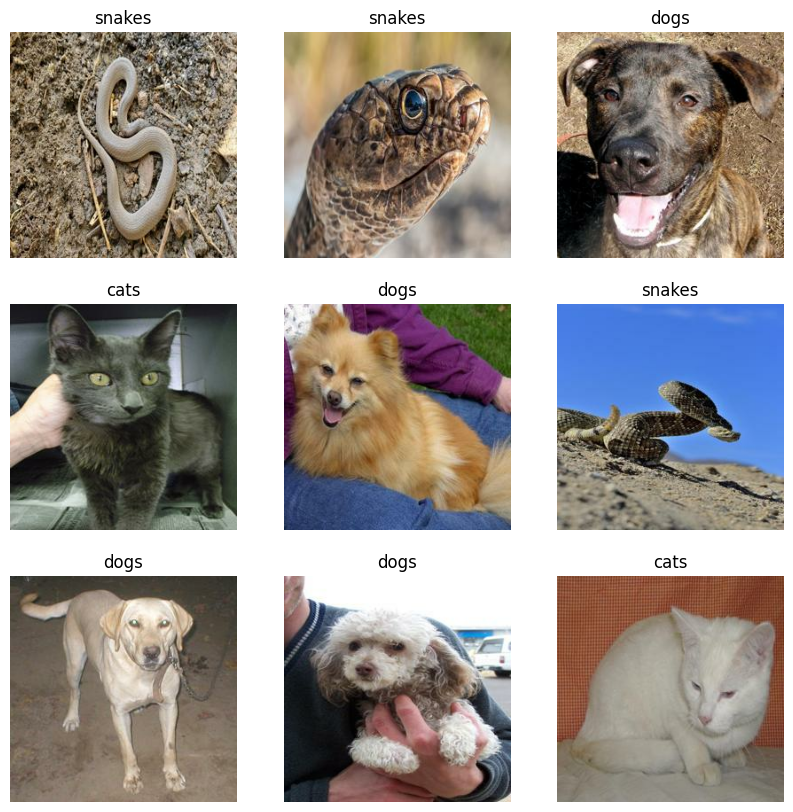

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(sample_train_img[i].astype("uint8"))
  plt.title(sample_train_lbl[i])
  plt.axis("off")

plt.show()

En el caso de aplicar un reescalado, veríamos la siguiente información:

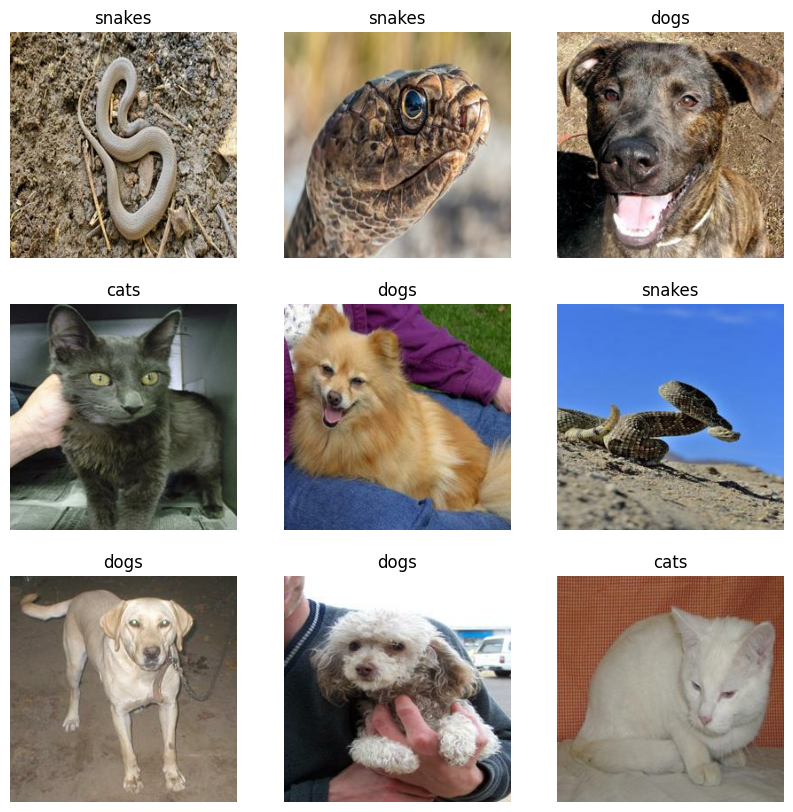

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = sample_train_img[i] / 255.0
  plt.imshow(img)
  plt.title(sample_train_lbl[i])
  plt.axis("off")

plt.show()

Unas líneas arriba verificamos los tamaños de las imágenes, ¿consideras necesario aplicar el reescalado?

---
# 3. Modelamiento.

## 3.1. Arquitectura de la red.

El esquema de una red neuronal convolucional, sería el siguiente:

![Redes Convolucionales](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%202/images/dcn.png?raw=true)

## 3.2. Implementación.

Vamos a definir nuestro modelo base:

In [23]:
model = Sequential(name="Mi_primer_RNC")

Capas de **Preparación de Datos**

In [24]:
model.add(Input(shape=(img_height, img_width, 3), batch_size=None, name='Capa_Entrada'))
model.add(Rescaling(1./255, name='Capa_Reescalado'))

model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Capas de **Entrenamiento**

Normalmente una CNN agrupan capas convolucionales, usan funciones de activación Relu, seguidos de otra capa que las agrupa (pooling) y así sucesivamente. Por lo tanto, a medida que la imagen avanza en la red, cuenta con más mapas de características por las convoluciones que va realizando.

Dicho paso de capas en la red, se verían de la siguiente forma:

![Redes Convolucionales 2](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%202/dcn_ejemplo.png?raw=true)

> Referencia:
Aurélien Géron, *"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow"*, 2a Edición, O'Reilly Media, 2019, Chapter 14, Figure 14-11.





Para implementar con ***Keras***, debemos hacer uso de las capas ***Conv2D***, ***MaxPooling2D*** y ***AveragePooling2D*** son componentes fundamentales en las redes neuronales convolucionales (CNN) que se utilizan ampliamente en tareas de visión por computadora, como el procesamiento de imágenes.



*   La capa ***Conv2D*** realiza la operación de convolución en una imagen de entrada, lo que implica generar un kernel (ventana pequeña) sobre la imagen y calcular los productos escalares entre los valores de píxeles de la imagen y los valores del kernel. Esto nos permite detectar patrones y características en la imagen, como bordes, texturas y detalles relevantes. Este tipo de capa requiere: el número de kernels, el tamaño del kernel y la función de activación:

> `Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_1')`


*   La capa ***MaxPooling2D*** realiza la operación de agrupación (pooling) en la imagen de entrada. En particular, realiza el max-pooling, que implica dividir la imagen en regiones y tomar el valor máximo de cada región. Esto permite reducir el tamaño espacial de la imagen, lo que reduce la cantidad de parámetros en la red y ayuda a aprender características invariantes a pequeñas traslaciones o deformaciones en la imagen. Este tipo de capa requiere: el tamaño de la ventana de agrupación y el paso (stride):

> `MaxPooling2D((2, 2), name='Max_Pool_1')`

>  En Keras, el valor predeterminado del stride para la capa MaxPooling2D es igual al tamaño de la ventana de agrupación, que en este caso es (2, 2)

*   La capa ***AveragePooling2D*** realiza una operación de agrupación en donde toma el valor promedio. Nos ayuda a reducir el tamaño espacial de la imagen y puede ayudar a aprender características invariantes. Este tipo de capa requiere: el tamaño de la ventana de agrupación y el paso (stride):

> `AveragePooling2D((2, 2), name='Avg_Pool_1')`

In [25]:
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_1'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
model.add(Conv2D(256, (3, 3), activation='relu', name='Capa_Convolucional_3'))
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 370,816 (1.41 MB)

 Trainable params: 370,816 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Capas de **Entrenamiento** Fully Connected (Lo haremos posible con un perceptron Multicapa)

In [26]:
model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(128,activation='relu',name='Capa_Densa_1'))
model.add(Dense(64,activation='relu',name='Capa_Densa_2'))
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │     117,964,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_2 (Dense)                 │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,344,000 (451.45 MB)

 Trainable params: 118,344,000 (451.45 MB)

 Non-trainable params: 0 (0.00 B)

Capa de **Salida**

In [27]:
model.add(Dense(len(class_names), activation='softmax', name='Capa_Respuesta'))
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │     117,964,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_2 (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Respuesta (Dense)               │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,344,195 (451.45 MB)

 Trainable params: 118,344,195 (451.45 MB)

 Non-trainable params: 0 (0.00 B)

Ya con nuestra arquitectura construida, compilamos nuestro modelo definiendo que función de pérdida, optimizador y métrica vamos a utilizar para construir nuestro modelo.

In [28]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │     117,964,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_2 (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Respuesta (Dense)               │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,344,195 (451.45 MB)

 Trainable params: 118,344,195 (451.45 MB)

 Non-trainable params: 0 (0.00 B)

Una manera más amigable de verlo...

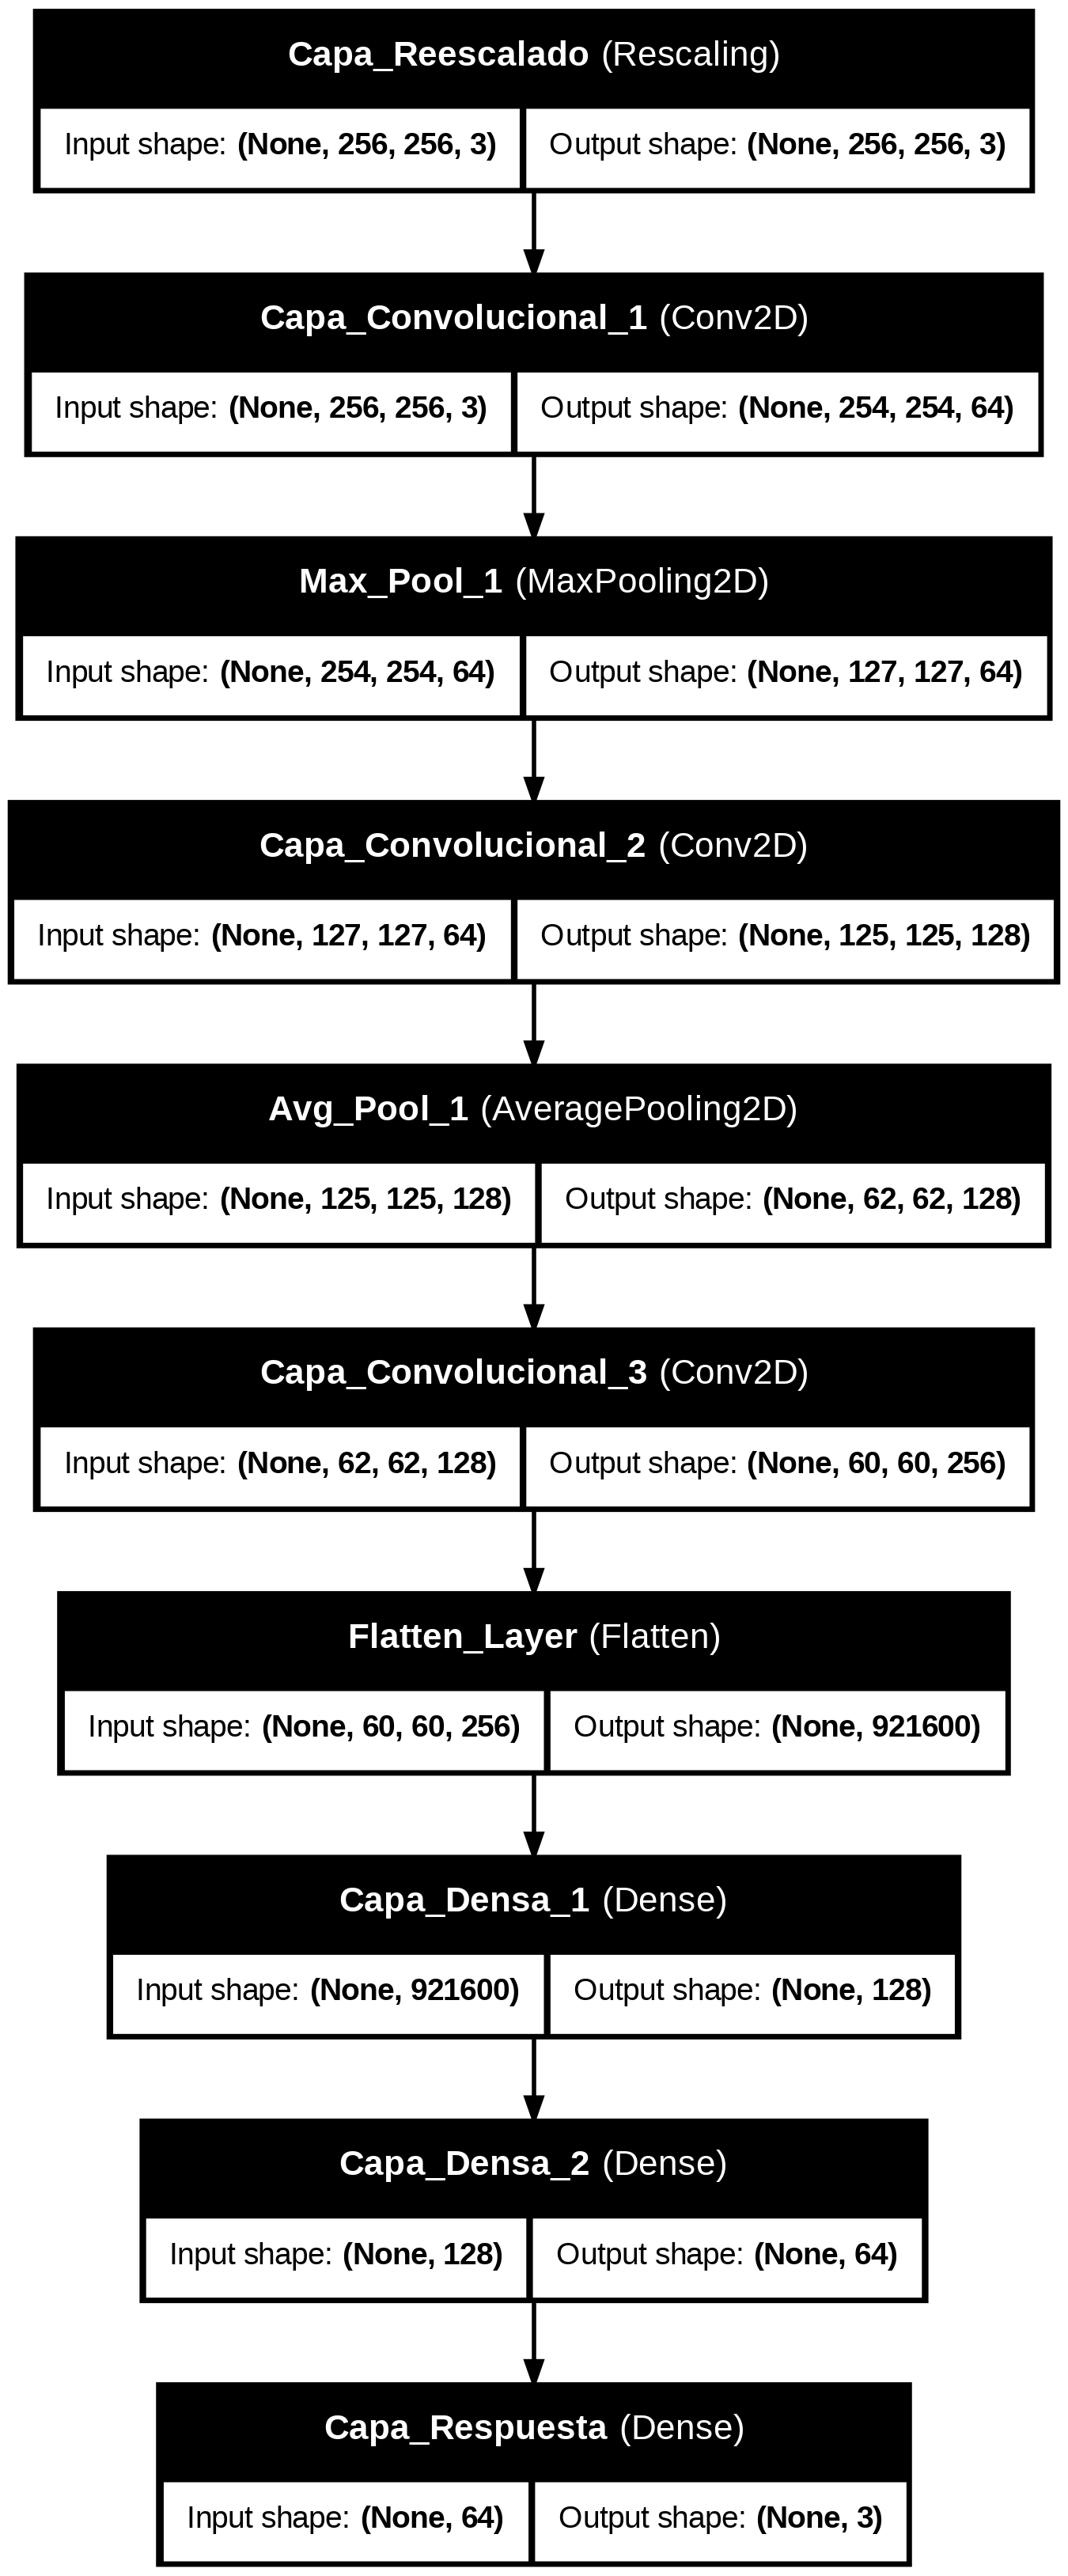

In [29]:
plot_model(model, show_shapes=True, show_layer_names=True)

En el caso que el entrenamiento no mejore, podemos definir una función de parada temprada mediante un EarlyStopping, allí definimos el parámetro de la paciencia y podemos especificar el número de épocas que esperaremos. La parada temprana irá en el callback de la siguiente forma:

In [30]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Ya con nuestro modelo construido y compilado. Ahora sí podemos pasar a entrenarlo.

In [31]:
with tf.device(gpu_name):
  history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
          callbacks=my_callbacks
  )

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 245ms/step - loss: 1.7087 - precision: 0.4627 - recall: 0.1249 - val_loss: 0.8923 - val_precision: 0.8142 - val_recall: 0.3067
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.8768 - precision: 0.7405 - recall: 0.2999 - val_loss: 0.7661 - val_precision: 0.7295 - val_recall: 0.5033
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.7418 - precision: 0.6902 - recall: 0.4886 - val_loss: 0.7736 - val_precision: 0.7080 - val_recall: 0.5900
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 0.5961 - precision: 0.7504 - recall: 0.6740 - val_loss: 0.7679 - val_precision: 0.7020 - val_recall: 0.5733
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - loss: 0.4234 - precision: 0.8378 - recall: 0.7838 - val_loss: 1.1137 - val_precision: 0.6690 - val_recall: 0.6467


## 3.4. Predicción.

Al igual que con nuestros modelos anteriores, podemos realizar predicciones en nuestro conjunto de datos. Sin embargo, en este caso, debemos realizar una pequeña corrección en el proceso. Para obtener las etiquetas verdaderas y las etiquetas predichas, hemos recorrido el conjunto de datos de entrenamiento. En cada iteración, hemos utilizado el modelo para predecir las clases y luego hemos aplicado un umbral de 0.5 para asignar etiquetas binarias (1 si la probabilidad es mayor a 0.5 y 0 en caso contrario). Posteriormente, hemos convertido las listas resultantes en arreglos numpy para su posterior análisis y evaluación.`

In [32]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

(array([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=float32),
 array([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        ...,
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]]))

Y utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [33]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

        cats       0.91      0.88      0.90       790
        dogs       0.88      0.92      0.90       809
      snakes       0.98      0.96      0.97       801

   micro avg       0.92      0.92      0.92      2400
   macro avg       0.93      0.92      0.92      2400
weighted avg       0.93      0.92      0.92      2400
 samples avg       0.92      0.92      0.92      2400



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


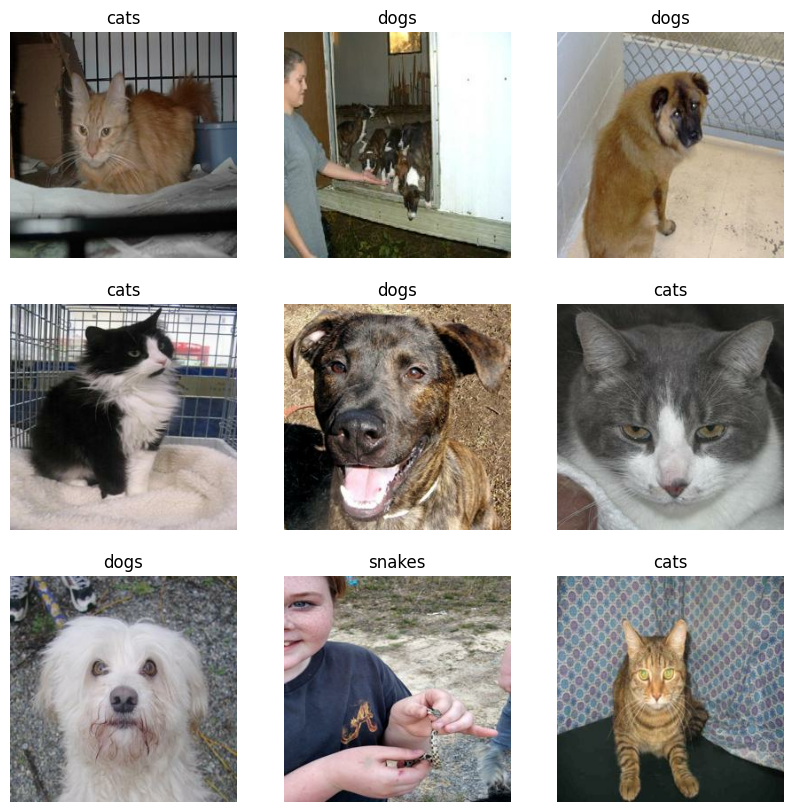

In [34]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
for images, labels in df:
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.

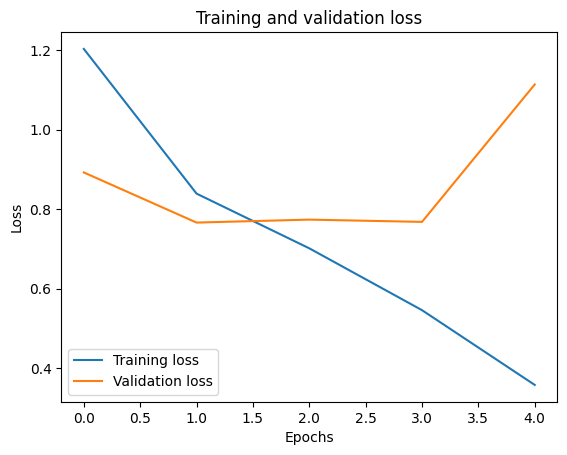

In [35]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

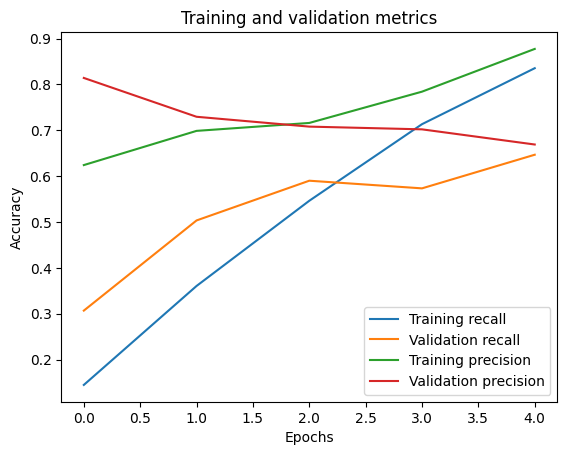

In [36]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Usando la gráfica anterior, ¿consideras que se presenta *overfitting*?

## 3.5. Validación.

In [37]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


(array([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0

In [38]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

              precision    recall  f1-score   support

        cats       0.70      0.56      0.62       107
        dogs       0.50      0.60      0.54        87
      snakes       0.79      0.82      0.81       106

   micro avg       0.66      0.66      0.66       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.67      0.66      0.66       300
 samples avg       0.66      0.66      0.66       300



Veamos la predicción aplicada en las imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


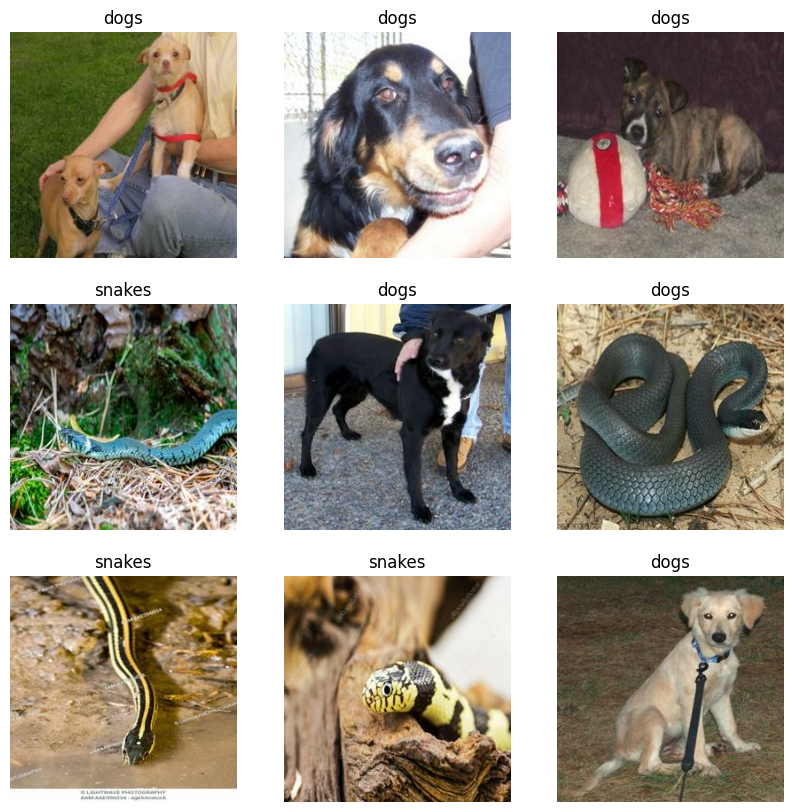

In [39]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
for images, labels in df:
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

¿Y si verificamos con los datos de prueba?

In [40]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0

In [41]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

              precision    recall  f1-score   support

        cats       0.70      0.56      0.62       107
        dogs       0.50      0.60      0.54        87
      snakes       0.79      0.82      0.81       106

   micro avg       0.66      0.66      0.66       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.67      0.66      0.66       300
 samples avg       0.66      0.66      0.66       300



Construye la tabla comparativa de rendimientos entre validación y de prueba. ¿Existe sobre ajuste?. ¿Clasifica bien el modelo?.

¿Y con las imágenes de prueba?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


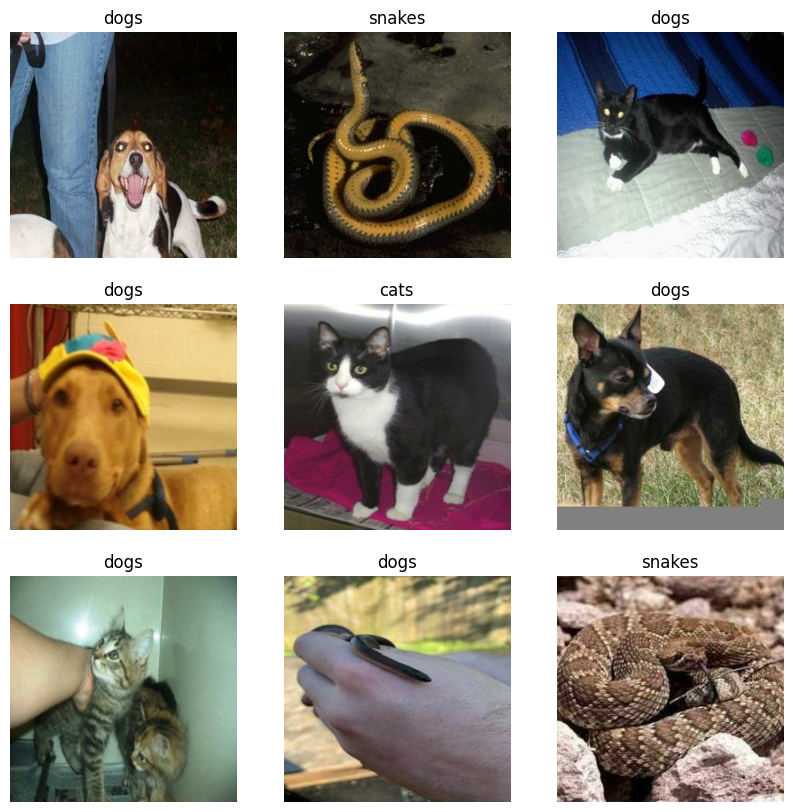

In [42]:
plt.figure(figsize=(10, 10))

df = test_ds.take(1)
for images, labels in df:
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

## 3.6. Búsqueda de hiperparámetros.

Existe la posibilidad de buscar muchos hiperparámetros en la búsqueda del mejor modelo. Sería posible usar un *GridSearch*, sin embargo, al construir la grilla, debe realizar más cálculos, toma más tiempo, demanda más recursos dado que requiere entrenar más hiperparámetros, por esta razón no es recomendable.

Para ello, construimos una función que nos permita construir la Red Neuronal esperada y utilizamos la función de búsqueda aleatoria con [RandomizedSearchCV](https://keras.io/guides/keras_tuner/getting_started/) integrada directamente con Keras.

In [43]:
def construirMejorModelo(hip):
  bModel = Sequential(name="Modelo_Simple")

  # Entrada
  bModel.add(Input(shape=(img_height, img_width, 3), name='Entrada'))

  # Reescalado
  bModel.add(Rescaling(1./255, name='Reescalado'))

  # Capas Convolucionales y de Pooling
  bModel.add(Conv2D(filters=hip.Int('conv_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hip.Choice('conv_kernel', values=[3, 5]),
                     activation='relu',
                     name='Convolucional_1'))

  bModel.add(MaxPooling2D((2, 2), name='MaxPooling_1'))

  bModel.add(Conv2D(filters=hip.Int('conv_filters_2', min_value=64, max_value=256, step=64),
                     kernel_size=hip.Choice('conv_kernel_2', values=[3, 5]),
                     activation='relu',
                     name='Convolucional_2'))

  bModel.add(MaxPooling2D((2, 2), name='MaxPooling_2'))

  # Capas Densas
  bModel.add(Flatten(name='Flatten'))
  bModel.add(Dense(units=hip.Int('dense_units', min_value=64, max_value=128, step=64),
                    activation='relu', name='Densa'))
  bModel.add(Dense(3, activation='softmax', name='Salida'))

  # Compilación del modelo
  bModel.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(),
                   metrics=["accuracy"])

  return bModel

Ya con nuestros valores de búsqueda definidos dentro de nuestra función, y nuestro objeto tuner inicializado. Podemor realizar la búsqueda de los hierparámetros como ya hemos venido realizandolo.

**Nota**: Este paso requiere el uso de GPU de la máquina de Google Colab, con el fin de realizar el proceso de entrenamiento mucho más rapido.

In [44]:
tuner = kt.RandomSearch(
    construirMejorModelo,
    objective="val_accuracy",
    project_name="cls_animal",
    seed=my_seed,
    max_trials=10)

In [45]:
with tf.device(gpu_name):
  tuner.search(train_ds, validation_data=val_ds, callbacks=my_callbacks, epochs=30)

Trial 10 Complete [00h 00m 43s]

Best val_accuracy So Far: 0.7233333587646484
Total elapsed time: 00h 12m 16s


Almacenamos el mejor modelo en una variable:

In [46]:
best_model = tuner.get_best_models()[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Y realizamos la descarga de nuestro modelo, junto con la vizualización de la arquitectura escogida por la búsqueda Aleatoria.

In [47]:
best_model.save('best_model_cls_animal.h5')
best_model.summary()

Model: "Modelo_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Reescalado (Rescaling)               │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolucional_1 (Conv2D)             │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling_1 (MaxPooling2D)          │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolucional_2 (Conv2D)             │ (None, 123, 123, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling_2 (MaxPooling2D)          │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 238144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Densa (Dense)                        │ (None, 128)                 │      30,482,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Salida (Dense)                       │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,535,107 (116.48 MB)

 Trainable params: 30,535,107 (116.48 MB)

 Non-trainable params: 0 (0.00 B)

Realizamos los mismos pasos que hicimos con nuestro modelo base, para poder comparar

In [48]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [49]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

        cats       0.86      0.71      0.78       790
        dogs       0.89      0.62      0.73       809
      snakes       0.95      0.89      0.92       801

   micro avg       0.90      0.74      0.81      2400
   macro avg       0.90      0.74      0.81      2400
weighted avg       0.90      0.74      0.81      2400
 samples avg       0.74      0.74      0.74      2400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Veamos la predicción con imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


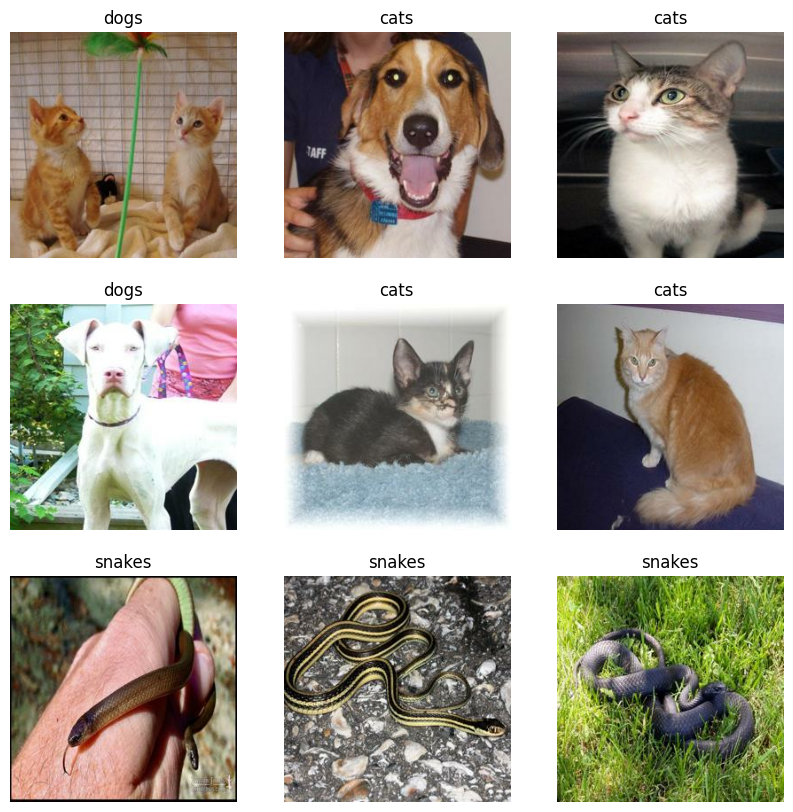

In [50]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
for images, labels in df:
  pred = best_model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

In [51]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Veamos el rendimiento con los datos de prueba:

In [52]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

        cats       0.71      0.51      0.60       107
        dogs       0.72      0.48      0.58        87
      snakes       0.88      0.87      0.87       106

   micro avg       0.79      0.63      0.70       300
   macro avg       0.77      0.62      0.68       300
weighted avg       0.77      0.63      0.69       300
 samples avg       0.63      0.63      0.63       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


¿Tiene mejor rendimiento este modelo?.

---
# 4. Preguntas.

- Cómo se vería la tabla comparativa de rendimiento entre los 2 modelos.
- Modifica el modelo inicial cambiando otros valores de padding y strike en las capas Conv2D. Ten en cuenta los valores por defecto que usa [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) son: strides=(1, 1), padding='valid'.
- ¿Qué ocurriría si realizo mi búsqueda a través de otro camino (función de costos, métricas)? ¿Obtendré un mejor resultado?
- ¿Qué pasaría si cambian los tamaños/valores de las capas de entrenamiento?
- ¿Cómo puedo corregir la "reducción" de las dimensiones de las imágenes dentro de cada capa de Pooling?
- ¿Qué otros hiperparámetros podemos ver dentro de las Redes Convolucionales?, ¿para que funciona el padding y el tamaño de la convolución?
- Ante la falta de recursos (tiempo, uso de GPU, espacio de búsqueda), ¿Y si utilizamos una red preentrenada? ¿Mejorará el rendimiento de nuestro modelo a un menor tiempo de entrenamiento? ¿Valdrá la pena el cambio?